In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 6:2:2
df = pd.read_csv('../../../Data/ETH-USD.csv')
df['Close'] = df['Close']
print(df)

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df['Close'].iloc[:train_size]
test_data = df['Close'].iloc[train_size:train_size+test_size]
val_data = df['Close'].iloc[train_size+test_size:]

            Date         Open         High          Low        Close  \
0      11/9/2017   308.644989   329.451996   307.056000   320.884003   
1     11/10/2017   320.670990   324.717987   294.541992   299.252991   
2     11/11/2017   298.585999   319.453003   298.191986   314.681000   
3     11/12/2017   314.690002   319.153015   298.513000   307.907990   
4     11/13/2017   307.024994   328.415009   307.024994   316.716003   
...          ...          ...          ...          ...          ...   
2039   6/10/2023  1840.391968  1844.785645  1721.443115  1752.384766   
2040   6/11/2023  1752.527588  1776.847168  1741.110474  1753.415283   
2041   6/12/2023  1753.075439  1757.659790  1722.906372  1742.528687   
2042   6/13/2023  1742.390137  1761.955444  1727.749878  1739.037598   
2043   6/14/2023  1739.250122  1749.163208  1637.187744  1650.519287   

        Adj Close       Volume  
0      320.884003    893249984  
1      299.252991    885985984  
2      314.681000    842300992  
3  

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.74 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=12805.308, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=12441.488, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=12300.435, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=12246.264, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=12177.128, Time=0.09 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=12103.319, Time=0.12 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.09 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=12105.318, Time=0.19 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 3.255 seconds


ARIMA(order=(5, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [5]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1800.80274708 1771.16236766 1752.81101162 1750.63154497 1740.95004603
 1726.7837948  1719.86768386 1703.9687558  1692.45528152 1683.27197477
 1671.84191403 1660.5122238  1649.71216108 1637.48596595 1626.46592648
 1615.61875608 1604.30366558 1593.11688027 1581.87725459 1570.47027147
 1559.3351657  1548.16993998 1536.92494646 1525.70980995 1514.462988
 1503.21109888 1492.01148374 1480.79422381 1469.56540211 1458.34074344]


In [6]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
# RMSE
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("The root mean squared error (RMSE) on test set: {:.3f}".format(rmse))
# EVS
evs = explained_variance_score(test_data, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))
#MAPE
mape = mean_absolute_percentage_error(test_data, y_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))

The root mean squared error (RMSE) on test set: 3983.879
The explained variance score (EVS) on test set: -4.440
The mean absolute percentage error (MAPE) on test set: 1.118


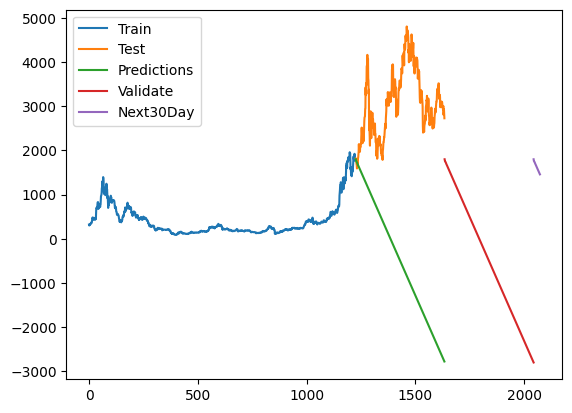

In [7]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [8]:
# test_data.index